In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import collections
import math
import re
import random
torch.cuda.is_available()

True

In [2]:
def read_time_machine():  #@save
    """将时间机器数据集加载到文本行的列表中"""
    with open("D:/DL_datasets/PTB/train.txt", 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'# 文本总行数: {len(lines)}')
print(lines[0])
print(lines[10])

# 文本总行数: 42068
aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack food ssangyong swapo wachter
there is no asbestos in our products now


In [3]:
def tokenize(lines, token='word'):  #@save
    """将文本行拆分为单词或字符词元"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：' + token)
tokens = tokenize(lines)

In [4]:
class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [5]:
def load_corpus_time_machine(max_tokens=-1):  #@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab
corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(4839378, 28)

In [6]:
def seq_data_iter_random(corpus, batch_size, num_steps): #@save
    """使⽤随机抽样⽣成⼀个⼩批量⼦序列"""
    # 从随机偏移量开始对序列进⾏分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # ⻓度为num_steps的⼦序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来⾃两个相邻的、随机的、⼩批量中的⼦序列不⼀定在原始序列上相邻
    random.shuffle(initial_indices)
    
    def data(pos):
        # 返回从pos位置开始的⻓度为num_steps的序列
        return corpus[pos: pos + num_steps]
 
    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这⾥，initial_indices包含⼦序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)
def seq_data_iter_sequential(corpus, batch_size, num_steps): #@save
    """使⽤顺序分区⽣成⼀个⼩批量⼦序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y
class SeqDataLoader: #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps
    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)
def load_data_time_machine(batch_size, num_steps, #@save
    use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

In [7]:
## 定义LSTM模型
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xi, W_hi, b_i = three()  # 输入门参数
    W_xf, W_hf, b_f = three()  # 遗忘门参数
    W_xo, W_ho, b_o = three()  # 输出门参数
    W_xc, W_hc, b_c = three()  # 候选记忆元参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q] = params
    (H, C) = state
    outputs = []
    It=[]
    Ft=[]
    Ot=[]
    C_tildat=[]
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
        It.append(I)
        Ft.append(F)
        Ot.append(O)
        C_tildat.append(C_tilda)
    return torch.cat(outputs, dim=0), (H, C), (It,Ft,Ot,C_tildat)

In [8]:
class RNNModelScratch: #@save
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [9]:
def grad_clipping(net, theta):  #@save
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [10]:
def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # 预热期
        _, state, gates = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测num_preds步
        y, state, gates = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])
#@save
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state, gates = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop(), gates
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    PPL=torch.empty(num_epochs)
    LSTM_gates=[]
    for epoch in range(num_epochs):
        ppl, speed, gates= train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)
        LSTM_gates.append(gates)
        PPL[epoch]=ppl
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))
    return net.params, gates, PPL, LSTM_gates

困惑度 11.4, 21621.6 词元/秒 cuda
time traveller on the the the the the the the the the the the th
traveller on the the the the the the the the the the the th


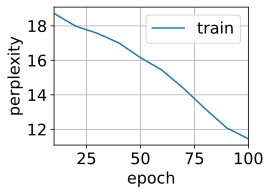

In [255]:
from d2l import torch as d2l
## 开始LSTM 训练
batch_size, num_steps = 32, 50   ## bum_steps 就是序列长度
train_iter, vocab = load_data_time_machine(batch_size, num_steps)
vocab_size, num_hiddens, device = 32, 128, torch.device('cuda') ## dx=32, dh=256
num_epochs, lr = 100, 1
model1 = RNNModelScratch(vocab_size, num_hiddens, device, get_lstm_params, init_lstm_state, lstm)
weights_LSTM, gates, PPL1, LSTM_gates=train_ch8(model1, train_iter, vocab, lr, num_epochs, device)

In [256]:
## 所有epochs的门控信息
# LSTM_gates_t=torch.empty(num_epochs,5,3);   ## 五种类型的t,三种门控
# k=2
# j=num_steps-1
# for i in range(num_epochs):
#     for j in range(num_steps):
#         LSTM_gates_t[i,k,0]=torch.norm(LSTM_gates[i][0][j], float('inf')).item()
#         LSTM_gates_t[i,k,1]=torch.norm(LSTM_gates[i][1][j], float('inf')).item()
#         LSTM_gates_t[i,k,2]=torch.norm(LSTM_gates[i][2][j], float('inf')).item()

In [257]:
# import matplotlib.pyplot as plt
# plt.rcParams['font.size'] = 16
# plt.plot(range(num_epochs), LSTM_gates_t[:,0,2].detach().numpy(), label="$t=10$")
# plt.plot(range(num_epochs), LSTM_gates_t[:,1,2].detach().numpy(), label="$t=20$")
# plt.plot(range(num_epochs), LSTM_gates_t[:,2,2].detach().numpy(), label="$t=30$")
# plt.plot(range(num_epochs), LSTM_gates_t[:,3,2].detach().numpy(), label="$t=40$")
# plt.plot(range(num_epochs), LSTM_gates_t[:,4,2].detach().numpy(), label="$t=50$")
# plt.title("Output gate")
# plt.xlabel("Epochs")
# plt.ylabel("$\|o_{t}\|_{\infty}$", fontsize=24)
# plt.legend(bbox_to_anchor=(0.66, 0.5))
# plt.savefig('C:/Users/Administrator/Desktop/LSTM/result/output_gate.pdf', dpi=200, bbox_inches='tight')

In [258]:
# import matplotlib.pyplot as plt
# plt.rcParams['font.size'] = 16
# plt.plot(range(num_epochs), LSTM_gates_t[:,0,2].detach().numpy(), marker='o', label="$t=10$")
# plt.plot(range(num_epochs), LSTM_gates_t[:,1,2].detach().numpy(), marker='s', label="$t=20$")
# plt.plot(range(num_epochs), LSTM_gates_t[:,2,2].detach().numpy(), marker='^', label="$t=30$")
# plt.plot(range(num_epochs), LSTM_gates_t[:,3,2].detach().numpy(), marker='d', label="$t=40$")
# plt.plot(range(num_epochs), LSTM_gates_t[:,4,2].detach().numpy(), marker='*', label="$t=50$")
# plt.xlabel("Epochs")
# plt.ylabel("$\|o_{t}\|_{\infty}$")
# plt.legend(bbox_to_anchor=(1, 1))
# plt.savefig('C:/Users/Administrator/Desktop/LSTM/result/output_gate.pdf', dpi=200, bbox_inches='tight')

In [259]:
import numpy as np
## 超参数设置
d=num_hiddens;
t=num_steps;
### 计算LSTM的复杂度
weights=weights_LSTM
## 输入门参数
Wr=weights[0];
Ur=weights[1];
## 遗忘门参数
Wf=weights[3];
Uf=weights[4];
## 输出门参数
Wo=weights[6];
Uo=weights[7];
## 候选单元参数
Wc=weights[9];
Uc=weights[10];
## h到y
V=weights[12];

In [260]:
#spectral norm about U
MUr=torch.linalg.norm(Ur, ord=2)
MUf=torch.linalg.norm(Uf, ord=2)
MUo=torch.linalg.norm(Uo, ord=2)
MUc=torch.linalg.norm(Uc, ord=2)
print(MUr,MUf,MUo,MUc)

tensor(2.4373, device='cuda:0', grad_fn=<AmaxBackward0>) tensor(0.5470, device='cuda:0', grad_fn=<AmaxBackward0>) tensor(2.5459, device='cuda:0', grad_fn=<AmaxBackward0>) tensor(1.6155, device='cuda:0', grad_fn=<AmaxBackward0>)


In [261]:
#Frobenius norm about U and W
BUr=torch.linalg.norm(Ur, ord='fro')
BUf=torch.linalg.norm(Uf, ord='fro')
BUo=torch.linalg.norm(Uo, ord='fro')
BUc=torch.linalg.norm(Uc, ord='fro')
BWr=torch.linalg.norm(Wr, ord='fro')
BWf=torch.linalg.norm(Wf, ord='fro')
BWo=torch.linalg.norm(Wo, ord='fro')
BWc=torch.linalg.norm(Wc, ord='fro')
BV=torch.linalg.norm(V, ord='fro')
print(BWr,BWf,BWo,BV)

tensor(1.0150, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>) tensor(1.0707, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>) tensor(1.4688, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>) tensor(7.8791, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


In [262]:
## 输入门输出
rt=gates[0]
## 遗忘门输出
ft=gates[1]
## 输出门输出
ot=gates[2]
## cell输入
ct_tilda=gates[3]
rt_tilde=rt[0]*(1-rt[0])
print(len(rt))
print(rt_tilde.shape)

50
torch.Size([32, 128])


In [263]:
gates_t=torch.empty(len(ft),3);
for j in range(len(rt)):
    gates_t[j,0]=torch.norm(rt[j], float('inf')).item()
    gates_t[j,1]=torch.norm(ft[j], float('inf')).item()
    gates_t[j,2]=torch.norm(ot[j], float('inf')).item()
print(gates_t[0:][0:5,:])
bj=torch.empty(len(ft)-1)
for k in range(1,len(rt)):
    bj[k-1]=gates_t[k,1]+gates_t[k,0]*gates_t[k-1,2]*MUc

tensor([[0.9318, 0.5964, 0.9408],
        [0.9373, 0.6026, 0.9447],
        [0.9315, 0.6003, 0.9449],
        [0.9354, 0.6001, 0.9411],
        [0.9262, 0.5990, 0.9445]])


In [264]:
Gates_t=torch.empty(len(ft),4);
for j in range(len(rt)):
    Gates_t[j,0]=torch.norm(rt[j]*(1-rt[j]), float('inf')).item()
    Gates_t[j,1]=torch.norm(ft[j]*(1-ft[j]), float('inf')).item()
    Gates_t[j,2]=torch.norm(ot[j]*(1-ot[j]), float('inf')).item()
    Gates_t[j,3]=torch.norm((1-ct_tilda[j]*ct_tilda[j]), float('inf')).item()
print(Gates_t[0:][0:5,:])
etaj=torch.empty(len(ft)-1)
for k in range(1,len(rt)):
    etaj[k-1]=Gates_t[k,0]*MUr+Gates_t[k,1]*MUf+Gates_t[k,2]*MUo+Gates_t[k,3]*MUc
theta_t=torch.ones(len(rt))
for i in range(1,len(rt)):
    theta_t[i]=i*math.prod(1+etaj[i:(len(rt)+1)])
print(theta_t)

tensor([[0.2500, 0.2500, 0.2500, 1.0000],
        [0.2500, 0.2500, 0.2500, 1.0000],
        [0.2500, 0.2500, 0.2500, 1.0000],
        [0.2500, 0.2500, 0.2500, 1.0000],
        [0.2500, 0.2500, 0.2500, 1.0000]])
tensor([1.0000e+00, 7.7415e+28, 3.8726e+28, 1.4529e+28, 4.8454e+27, 1.5149e+27,
        4.5470e+26, 1.3268e+26, 3.7928e+25, 1.0672e+25, 2.9660e+24, 8.1604e+23,
        2.2266e+23, 6.0334e+22, 1.6252e+22, 4.3552e+21, 1.1619e+21, 3.0879e+20,
        8.1778e+19, 2.1591e+19, 5.6845e+18, 1.4929e+18, 3.9119e+17, 1.0229e+17,
        2.6698e+16, 6.9559e+15, 1.8094e+15, 4.6997e+14, 1.2190e+14, 3.1580e+13,
        8.1711e+12, 2.1119e+12, 5.4527e+11, 1.4064e+11, 3.6244e+10, 9.3320e+09,
        2.4008e+09, 6.1718e+08, 1.5854e+08, 4.0698e+07, 1.0440e+07, 2.6766e+06,
        6.8581e+05, 1.7562e+05, 4.4948e+04, 1.1498e+04, 2.9397e+03, 7.5128e+02,
        1.9191e+02, 4.9000e+01], grad_fn=<CopySlices>)


In [265]:
bt=0;
for i in range(1,len(ft)):
    bt=bt+math.prod(bj[:i])
print(bt)

tensor(1.9181e+15, grad_fn=<AddBackward0>)


In [266]:
# Rademacher_LSTM=torch.empty(10,5);
j=0
for n in range(10000,100001,10000):
    alphat=max(n*math.sqrt(d),BWc*(1+bt));
    logalphat=torch.log10(alphat);
    logthetat=torch.log10(BV*sum(theta_t));
    loggt=max(torch.log10(max(BWr,BWf,BWo,BWc,BUr,BUf,BUo,BUc))+logthetat,logalphat)+torch.log10(BV);
    Rademacher_LSTM[j,4]=np.log10(d)+loggt+np.log10(np.sqrt(np.log10(d)))+torch.log10(torch.log10(BV*n))+torch.log10(logalphat)-np.log10(n)
    j=j+1
print(Rademacher_LSTM)

tensor([[12.2982, 19.3794, 25.3111, 27.9462, 31.9829],
        [12.0210, 19.1031, 25.0353, 27.6709, 31.7078],
        [11.8582, 18.9409, 24.8734, 27.5091, 31.5462],
        [11.7425, 18.8255, 24.7582, 27.3941, 31.4312],
        [11.6526, 18.7359, 24.6687, 27.3047, 31.3419],
        [11.5791, 18.6626, 24.5955, 27.2316, 31.2688],
        [11.5169, 18.6005, 24.5335, 27.1697, 31.2069],
        [11.4630, 18.5467, 24.4798, 27.1161, 31.1533],
        [11.4154, 18.4992, 24.4324, 27.0687, 31.1060],
        [11.3728, 18.4567, 24.3900, 27.0263, 31.0636]], grad_fn=<CopySlices>)


In [267]:
for i in range(1,len(bj)):
    bj[i]=1+MUc
    etaj[i]=0.25*MUr+0.25*MUf+0.25*MUo+MUc

In [268]:
for i in range(1,len(ft)):
    bt=bt+math.prod(bj[:i])
print(bt)
for i in range(1,len(rt)):
    theta_t[i]=i*math.prod(1+etaj[i:(len(rt)+1)])
print(theta_t)
# Rademacher_LSTM2=torch.empty(10,5);
j=0
for n in range(10000,100001,10000):
    alphat=max(n*math.sqrt(d),BWc*(1+bt));
    logalphat=torch.log10(alphat);
    logthetat=torch.log10(BV*sum(theta_t));
    loggt=max(torch.log10(max(BWr,BWf,BWo,BWc,BUr,BUf,BUo,BUc))+logthetat,logalphat)+torch.log10(BV);
    Rademacher_LSTM2[j,4]=np.log10(d)+loggt+np.log10(np.sqrt(np.log10(d)))+torch.log10(torch.log10(BV*n))+torch.log10(logalphat)-np.log10(n)
    j=j+1
print(Rademacher_LSTM2)

tensor(3.6225e+20, grad_fn=<AddBackward0>)
tensor([1.0000e+00, 7.7419e+28, 3.8728e+28, 1.4530e+28, 4.8457e+27, 1.5150e+27,
        4.5472e+26, 1.3269e+26, 3.7930e+25, 1.0673e+25, 2.9661e+24, 8.1608e+23,
        2.2267e+23, 6.0337e+22, 1.6252e+22, 4.3554e+21, 1.1620e+21, 3.0880e+20,
        8.1781e+19, 2.1592e+19, 5.6847e+18, 1.4930e+18, 3.9120e+17, 1.0230e+17,
        2.6699e+16, 6.9561e+15, 1.8095e+15, 4.6999e+14, 1.2191e+14, 3.1580e+13,
        8.1713e+12, 2.1119e+12, 5.4528e+11, 1.4065e+11, 3.6245e+10, 9.3322e+09,
        2.4009e+09, 6.1718e+08, 1.5854e+08, 4.0698e+07, 1.0440e+07, 2.6767e+06,
        6.8581e+05, 1.7562e+05, 4.4948e+04, 1.1498e+04, 2.9398e+03, 7.5128e+02,
        1.9191e+02, 4.9000e+01], grad_fn=<CopySlices>)
tensor([[12.3239, 19.4038, 25.3609, 28.0490, 32.1056],
        [12.0467, 19.1275, 25.0852, 27.7737, 31.8305],
        [11.8840, 18.9653, 24.9232, 27.6120, 31.6688],
        [11.7683, 18.8499, 24.8080, 27.4970, 31.5539],
        [11.6784, 18.7603, 24.7186, 27.407

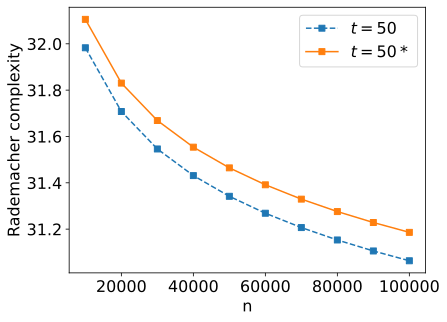

In [269]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16
# plt.plot(range(10000, 100001, 10000), Rademacher_LSTM[:,0].detach().numpy(), marker='o',linestyle='--', label="$t=10$")
plt.plot(range(10000, 100001, 10000), Rademacher_LSTM[:,1].detach().numpy(), marker='s',linestyle='--', label="$t=20$")
# plt.plot(range(10000, 100001, 10000), Rademacher_LSTM[:,2].detach().numpy(), marker='^',linestyle='--', label="$t=30$")
# plt.plot(range(10000, 100001, 10000), Rademacher_LSTM[:,3].detach().numpy(), marker='d',linestyle='--', label="$t=40$")
# plt.plot(range(10000, 100001, 10000), Rademacher_LSTM[:,4].detach().numpy(), marker='*',linestyle='--', label="$t=50$")
# plt.plot(range(10000, 100001, 10000), Rademacher_LSTM2[:,0].detach().numpy(), marker='o', label="$t=10*$")
plt.plot(range(10000, 100001, 10000), Rademacher_LSTM2[:,1].detach().numpy(), marker='s', label="$t=20*$")
# plt.plot(range(10000, 100001, 10000), Rademacher_LSTM2[:,2].detach().numpy(), marker='^', label="$t=30*$")
# plt.plot(range(10000, 100001, 10000), Rademacher_LSTM2[:,3].detach().numpy(), marker='d', label="$t=40*$")
# plt.plot(range(10000, 100001, 10000), Rademacher_LSTM2[:,4].detach().numpy(), marker='*', label="$t=50*$")
plt.xlabel("n")
plt.ylabel("Rademacher complexity")
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig('C:/Users/Administrator/Desktop/LSTM/result/t_20.pdf', dpi=200, bbox_inches='tight')

In [249]:
# import matplotlib.pyplot as plt
# plt.rcParams['font.size'] = 16
# plt.plot(range(10000, 100001, 10000), Rademacher_LSTM[:,0].detach().numpy(), marker='o', label="$d_{h}=32$")
# plt.plot(range(10000, 100001, 10000), Rademacher_LSTM[:,1].detach().numpy(), marker='s', label="$d_{h}=64$")
# plt.plot(range(10000, 100001, 10000), Rademacher_LSTM[:,2].detach().numpy(), marker='^', label="$d_{h}=128$")
# plt.plot(range(10000, 100001, 10000), Rademacher_LSTM[:,3].detach().numpy(), marker='d', label="$d_{h}=256$")
# plt.plot(range(10000, 100001, 10000), Rademacher_LSTM[:,4].detach().numpy(), marker='*', label="$d_{h}=512$")
# plt.xlabel("n")
# plt.ylabel("Rademacher complexity")
# plt.legend(bbox_to_anchor=(1, 1))
# plt.savefig('C:/Users/Administrator/Desktop/LSTM/result/d_32_to_512.pdf', dpi=200, bbox_inches='tight')